In [1]:
import src.algs as algs
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

/homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-12 11:18:41,685 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2026-01-12 11:18:41,800 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


6 6 6


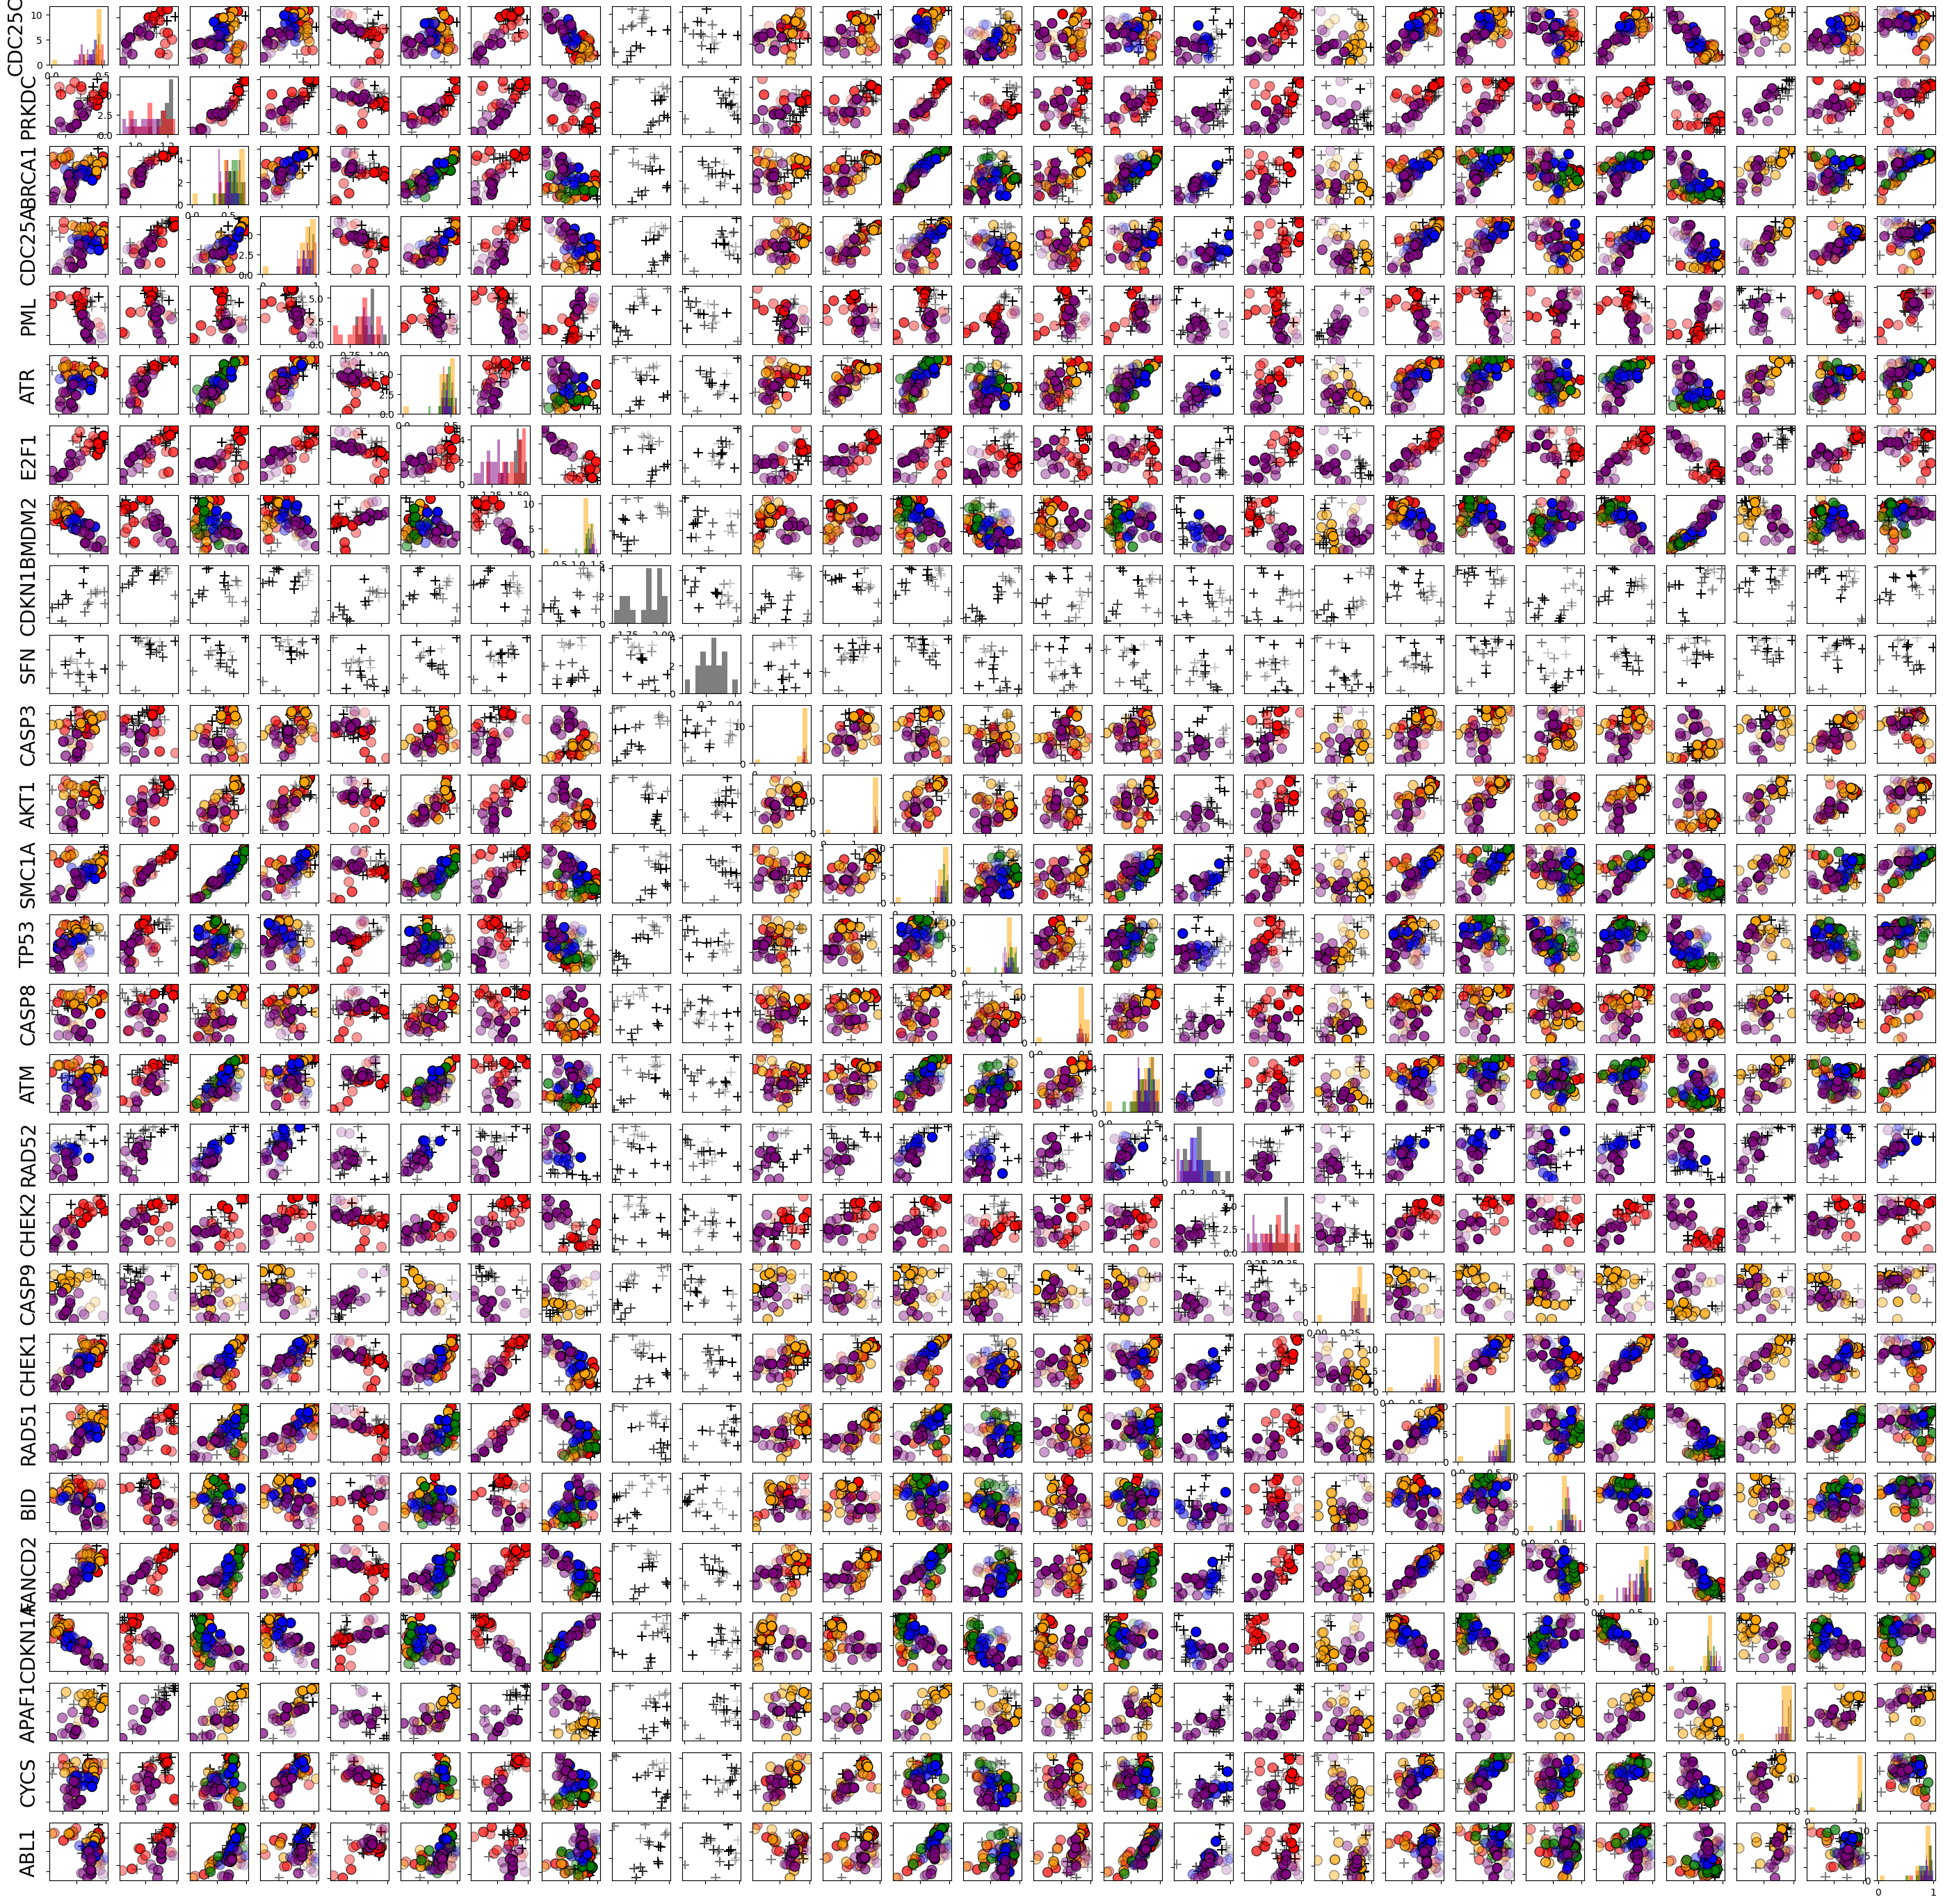

In [51]:
#doses = ["A", "B", "C", "D", "E"]
doses = ["0", "F", "G", "H", "I", "J"]
dose_rates = [0, 0.004, 0.04, 0.4, 4, 8]
#calculated_dose = [0 if week_num[1]=='0' else val*168*int(week_num[4]) for week_num,_ in matrix_by_dose_de.iterrows()]

colors = ['black', 'red', 'orange', 'green', 'blue', 'purple'] #mpl.colormaps["YlGn"] 
markers = [f'{i}' for i in np.arange(10)]
fig = plt.figure(figsize=(35,35))
dfs = []
genes = set()
for d, dose_rate in zip(doses, dose_rates):
    #df = pd.read_csv(f"./data/huvec/cd_matrix_d{d}.csv", header=0)
    df = pd.read_csv(f"./data/rpe1_experiment2/cd_tpm_matrix__fixed_d{d}.csv", header=0)

    de_genes = df.columns
    ddr_pathway = pd.read_csv("./data/prior_knowledge/WP707 - DNA damage response - Homo sapiens default edge.csv", header=0)["name"]
    ddr_edges_split = [re.split(r'[()]', data) for data in ddr_pathway ]
    # print(ddr_edges_split)
    ddr_edges = [(data[0].replace(" ",""), data[-1].replace(" ","")) for data in ddr_edges_split ]
    # print(ddr_edges)
    # print(len(ddr_edges))
    ddr_edges_in_data = [edge for edge in ddr_edges if (edge[0] in de_genes) and (edge[1] in de_genes)]
    # print(ddr_edges_in_data)
    # print(len(ddr_edges_in_data))
    G_star = nx.DiGraph()
    G_star.add_edges_from(ddr_edges_in_data)
    pos = nx.planar_layout(G_star) 
    # ax_graph = plt.subplot()
    # nx.draw(G_star, pos, with_labels=True, node_color='lightblue', 
    #         node_size=1500, font_size=10, font_weight='bold', ax=ax_graph)
    # plt.show()
    ddr_genes = set()
    for edge in ddr_edges_in_data:
        ddr_genes.add(edge[0])
        ddr_genes.add(edge[1])
    # print(ddr_genes)
    # print(len(ddr_genes))
    ddr_genes = list(ddr_genes)
    df_ddr_norm = np.log10(df[ddr_genes]+1)
    df_ddr_norm['radiation'] = df['radiation']
    df_ddr_norm['week'] = df['week']
    df_ddr_norm['dose_rate'] = np.ones(df_ddr_norm.shape[0])*dose_rate

    # df_ddr_norm['week'] = np.array([int(rad/(dose_rate*168)) if rad !=0 else 0 for rad in df_ddr_norm['radiation']])
   
    df_ddr = df[ddr_genes]
    genes = genes.union(set(ddr_genes))
    dfs.append(df_ddr_norm)
axs = []
y_min = 0
y_max=3
x_min = 0
x_max=3
color_values = np.linspace(0,1,len(dfs))
print(len(dfs), len(doses), len(color_values))
genes = list(genes)
for i,gene1 in enumerate(genes):
    for j,gene2 in enumerate(genes):
        for c,df_ddr_norm in enumerate(dfs):
            if c == 0:
                ax = plt.subplot2grid((len(genes), len(genes)), (i, j))
                axs.append(ax)
            else:
                ax = axs[len(genes)*i + j]
            if j==0:
                ax.set_ylabel(gene1)
                ax.yaxis.get_label().set_fontsize(20)
            # if i == 0:
            #     ax.set_title(gene2)
            #     ax.title.get_label().set_fontsize(30)
            #color = colors(color_values[c])
            color = colors[c]
            if (gene1 in df_ddr_norm.columns) and (gene2 in df_ddr_norm.columns):
                if gene1 == gene2:
                    #ax.hist(np.log10(df_ddr[gene1] + 10))
                    ax.hist(df_ddr_norm[gene1], color=color, alpha=0.5)
                else:
                    #ax.scatter(np.log10(df_ddr[gene1] + 10), np.log10(df_ddr[gene2] + 10))
                    df_ddr_norm_controls = df_ddr_norm.loc[df_ddr_norm['radiation']==0]
                    df_ddr_norm_treated = df_ddr_norm.loc[df_ddr_norm['radiation']!=0]
                    df_ddr_norm_treated = df_ddr_norm_treated.loc[df_ddr_norm_treated['week'] != 2].loc[df_ddr_norm_treated['week'] != 7]
                    if c!= 0:
                        ax.scatter(df_ddr_norm_treated[gene1], df_ddr_norm_treated[gene2], s=100, color=color, label=doses[c], alpha = (df_ddr_norm_treated['week']+1)/10, edgecolors="black")
                    else:
                        ax.scatter(df_ddr_norm_controls[gene1], df_ddr_norm_controls[gene2], marker='+', s=100, color=color, label=doses[c], alpha = (df_ddr_norm_controls['week']+1)/10)

                    ax.xaxis.set_major_formatter(plt.NullFormatter())
                    ax.yaxis.set_major_formatter(plt.NullFormatter())
            else:
                if gene1 !=gene2:
                    ax.xaxis.set_major_formatter(plt.NullFormatter())
                    ax.yaxis.set_major_formatter(plt.NullFormatter())

plt.show()


In [18]:
ddr_filter_outliers = df_ddr_norm.loc[df_ddr_norm['week'] != 2].loc[df_ddr_norm['week'] != 7]


In [15]:
df_ddr_norm['dose_rate']

0     8.0
1     8.0
2     8.0
3     8.0
4     8.0
5     8.0
6     8.0
7     8.0
8     8.0
9     8.0
10    8.0
11    8.0
12    8.0
13    8.0
14    8.0
15    8.0
16    8.0
17    8.0
Name: dose_rate, dtype: float64

In [ ]:
def adj_to_edges(adj, colnames):
    edges = []
    for i,g1 in enumerate(colnames):
        for j, g2 in enumerate(colnames):
            if i !=j:
                if adj[i][j] != 0:
                    if adj[i][j] == adj[j][i]: # if end points are the same this is an undirected edge
                        edges.append((g1,g2))
                        edges.append((g2,g1))
                    else: # otherwise this is a directed edge
                        edges.append((g1,g2))
    print(len(edges))
    return(edges)
                        
def true_positive_rate(est_edges, true_edges):
    count = 0
    for e in true_edges:
        if e in est_edges:
            count +=1
            print(e)
    print(count, count/len(true_edges))
    return count/len(true_edges)

In [16]:
ges_est = algs.ges_bic_tetrad_local_learn(df_ddr_norm, seed=0) # ges is better on log norm data
pc_est = algs.pc_fisherz_tetrad_local_learn(df_ddr, seed=0) # pc is the same
dag_gnn_est = algs.dag_gnn_local_learn(df_ddr, seed=0) # dag_gnn is better with tpm data

2026-01-12 14:18:22,462 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:165] - INFO: GPU is available.


cuda


2026-01-12 14:18:23,766 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.2429249775597206
2026-01-12 14:18:27,540 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.1677191221758072
2026-01-12 14:18:28,795 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.1677191221758072
2026-01-12 14:18:30,050 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 1.1677191221758072
2026-01-12 14:18:31,332 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INF

In [17]:
true_positive_rate(adj_to_edges(ges_est, ddr_genes), ddr_edges_in_data)
true_positive_rate(adj_to_edges(pc_est, ddr_genes), ddr_edges_in_data)
true_positive_rate(adj_to_edges(dag_gnn_est, ddr_genes), ddr_edges_in_data)

82
('TP53', 'CDKN1A')
('CASP8', 'CASP3')
('ATM', 'BRCA1')
('ATR', 'BRCA1')
('CHEK1', 'CDC25C')
5 0.19230769230769232
40
('CASP8', 'CASP3')
1 0.038461538461538464
74
('CHEK1', 'CDC25A')
('TP53', 'CDKN1A')
('CASP8', 'CASP3')
('CHEK2', 'CDC25C')
('BID', 'CYCS')
5 0.19230769230769232


0.19230769230769232

In [34]:
ges_est = algs.ges_bic_tetrad_local_learn(ddr_filter_outliers, seed=0) # ges is better on log norm data
# pc_est = algs.pc_fisherz_tetrad_local_learn(ddr_filter_outliers, seed=0) # pc is the same
dag_gnn_est = algs.dag_gnn_local_learn(ddr_filter_outliers, seed=0) # dag_gnn is better with tpm data

2026-01-12 14:56:42,435 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:165] - INFO: GPU is available.


cuda


2026-01-12 14:56:43,873 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 1.6180426685905829
2026-01-12 14:56:50,984 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 1.6403458213588387
2026-01-12 14:56:52,397 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 299, h_new: 1.6403458213588387
2026-01-12 14:56:53,826 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 299, h_new: 1.6403458213588387
2026-01-12 14:56:55,255 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INF

In [35]:
true_positive_rate(adj_to_edges(ges_est, ddr_genes), ddr_edges_in_data)
true_positive_rate(adj_to_edges(dag_gnn_est, ddr_genes), ddr_edges_in_data)

118
('ATM', 'SMC1A')
('TP53', 'CDKN1A')
('CASP8', 'CASP3')
('CHEK2', 'PML')
('ATM', 'FANCD2')
5 0.19230769230769232
3
0 0.0


0.0

In [ ]:
df_combined = pd.concat(dfs)
ges_est = algs.ges_bic_tetrad_local_learn(df_combined, seed=0) # ges is better on log norm data
edges = adj_to_edges(ges_est, df_combined.columns)
print(edges)
true_positive_rate(adj_to_edges(ges_est, df_combined.columns), ddr_edges_in_data)

506
[('CDC25C', 'PRKDC'), ('CDC25C', 'BRCA1'), ('CDC25C', 'CDC25A'), ('CDC25C', 'PML'), ('CDC25C', 'ATR'), ('CDC25C', 'E2F1'), ('CDC25C', 'CDKN1B'), ('CDC25C', 'SFN'), ('CDC25C', 'AKT1'), ('CDC25C', 'SMC1A'), ('CDC25C', 'TP53'), ('CDC25C', 'CASP8'), ('CDC25C', 'ATM'), ('CDC25C', 'RAD52'), ('CDC25C', 'CHEK2'), ('CDC25C', 'CASP9'), ('CDC25C', 'CHEK1'), ('CDC25C', 'RAD51'), ('CDC25C', 'BID'), ('CDC25C', 'FANCD2'), ('CDC25C', 'CDKN1A'), ('CDC25C', 'APAF1'), ('CDC25C', 'CYCS'), ('CDC25C', 'week'), ('PRKDC', 'CDC25C'), ('PRKDC', 'BRCA1'), ('PRKDC', 'CDC25A'), ('PRKDC', 'ATR'), ('PRKDC', 'E2F1'), ('PRKDC', 'MDM2'), ('PRKDC', 'SFN'), ('PRKDC', 'CASP3'), ('PRKDC', 'AKT1'), ('PRKDC', 'SMC1A'), ('PRKDC', 'TP53'), ('PRKDC', 'CASP8'), ('PRKDC', 'ATM'), ('PRKDC', 'CASP9'), ('PRKDC', 'CHEK1'), ('PRKDC', 'BID'), ('PRKDC', 'FANCD2'), ('PRKDC', 'APAF1'), ('PRKDC', 'week'), ('PRKDC', 'dose_rate'), ('BRCA1', 'CDC25C'), ('BRCA1', 'PRKDC'), ('BRCA1', 'CDC25A'), ('BRCA1', 'ATR'), ('BRCA1', 'MDM2'), ('BRCA1',

0.7307692307692307

In [50]:
df_combined = pd.concat(dfs)
df_combined = df_combined.drop(columns=['radiation', 'week', 'dose_rate'])
print(df_combined.columns)
dag_gnn_est = algs.dag_gnn_local_learn(df_combined, seed=0) # dag_gnn is better with tpm data
true_positive_rate(adj_to_edges(pc_est, df_combined.columns), ddr_edges_in_data)


2026-01-12 15:20:47,264 - /homes/shahashka/.conda/envs/lucid_cd/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:165] - INFO: GPU is available.


Index(['CDC25C', 'PRKDC', 'BRCA1', 'CDC25A', 'PML', 'ATR', 'E2F1', 'MDM2',
       'CDKN1B', 'SFN', 'CASP3', 'AKT1', 'SMC1A', 'TP53', 'CASP8', 'ATM',
       'RAD52', 'CHEK2', 'CASP9', 'CHEK1', 'RAD51', 'BID', 'FANCD2', 'CDKN1A',
       'APAF1', 'CYCS', 'ABL1'],
      dtype='object')
cuda


ValueError: The loss value is Nan, suggest to set optimizer='adam' to solve it. If you already set, please check your code whether has other problems.